# Spring Reverb Dataset: pre-processing and conversion

In [44]:
import h5py
import os
import numpy as np
import torch
import torchaudio
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import essentia as es
import essentia.standard as estd
import essentia.streaming as esstr
import librosa

from src.utils import get_media_length
%matplotlib inline

## Download the dataset

The dataset is available at the following link: https://zenodo.org/record/3746119

A [Python Script](download_dataset.py) is provided to download the dataset and extract it in the current directory.

In [45]:
# Setting up the directories and the sample rate

CONVERTED_DIR = "audio/springset_converted"
PROCESSED_DIR = "audio/processed"
RESULTS_DIR = "results/"
MODELS_DIR = "models/"

sample_rate = 16000

DATA_DIR = "../datasets/plate-spring/"
spring_dir = Path(DATA_DIR) / 'spring'

In [46]:
print(h5py.version.info)

Summary of the h5py configuration
---------------------------------

h5py    3.9.0
HDF5    1.12.2
Python  3.11.4 (main, Aug 16 2023, 17:56:40) [Clang 12.0.0 (clang-1200.0.32.29)]
sys.platform    darwin
sys.maxsize     9223372036854775807
numpy   1.24.3
cython (built with) 0.29.35
numpy (built against) 1.23.2
HDF5 (built against) 1.12.2



## Read the data

In [47]:
# List and read the files in the dataset folder

data_dict = {}

for file in os.listdir(spring_dir):
    if file.endswith(('.h5')):
        file_path = os.path.join(spring_dir, file)
        with h5py.File(os.path.join(spring_dir, file), 'r') as f_handler:
            key = list(f_handler.keys())[0]
            data = f_handler[key]
            print(f"File: {file}")
            print(f"Keys: {key}")
            if len(data.attrs) > 0:
                print("Metadata attributes found:")
            for attr_name, attr_value in data.attrs.items():
                print(f"{attr_name}: {attr_value}")
            else:
                print("No metadata attributes found.")
            
            print(f"Type of ['{key}']: {type(data[:])}")
            print(f"Data shape: {data.shape}")
            print(f"Data type: {data.dtype}")
    
            data_dict[key] = data[:]  

            print("")

File: wet_val_test.h5
Keys: Yvalidation_0
No metadata attributes found.
Type of ['Yvalidation_0']: <class 'numpy.ndarray'>
Data shape: (64, 32000, 1)
Data type: float64

File: wet_train.h5
Keys: Ytrain_0
No metadata attributes found.
Type of ['Ytrain_0']: <class 'numpy.ndarray'>
Data shape: (1122, 32000, 1)
Data type: float64

File: dry_train.h5
Keys: Xtrain
No metadata attributes found.
Type of ['Xtrain']: <class 'numpy.ndarray'>
Data shape: (1122, 32000, 1)
Data type: float64

File: dry_val_test.h5
Keys: Xvalidation
No metadata attributes found.
Type of ['Xvalidation']: <class 'numpy.ndarray'>
Data shape: (64, 32000, 1)
Data type: float64



***The data is organized in the following way: `(index, samples, channels)`***

No attributes have been found in the data.

In [48]:
# Load each part of the dataset into a variable
X_train = data_dict['Xtrain']
Y_train = data_dict['Ytrain_0']
X_test = data_dict['Xvalidation']
Y_test = data_dict['Yvalidation_0']

# Print the shape of each part of the dataset
print('Xtrain shape:', X_train.shape)
print('Ytrain shape:', Y_train.shape)
print('Xtest shape:', X_test.shape)
print('Ytest shape:', Y_test.shape)

Xtrain shape: (1122, 32000, 1)
Ytrain shape: (1122, 32000, 1)
Xtest shape: (64, 32000, 1)
Ytest shape: (64, 32000, 1)


## Create a random subset and convert it to .wav

In [49]:
# Set the number of random samples to select
num_samples = 64

# Select random samples from Xtrain and Ytrain_0
random_indices = np.random.choice(len(X_train), size=num_samples, replace=False)

rand_X_train = X_train[random_indices]
rand_Y_train = Y_train[random_indices]

# Select random samples from Xvalidation and Yvalidation_0
random_indices = np.random.choice(len(X_test), size=num_samples, replace=False)

rand_X_test = X_test[random_indices]
rand_Y_test = Y_test[random_indices]

print(rand_X_train.shape, rand_Y_train.shape, rand_X_test.shape, rand_Y_test.shape)

(64, 32000, 1) (64, 32000, 1) (64, 32000, 1) (64, 32000, 1)


In [50]:
# Stack the randomly selected samples for Xtrain and Ytrain_0
stack_X_train = np.vstack(rand_X_train)
stack_Y_train = np.vstack(rand_Y_train)

# Stack the randomly selected samples for Xvalidation and Yvalidation_0
stack_X_test = np.vstack(rand_X_test)
stack_Y_test = np.vstack(rand_Y_test)

print(stack_X_train.shape, stack_Y_train.shape, stack_X_test.shape, stack_Y_test.shape)

(2048000, 1) (2048000, 1) (2048000, 1) (2048000, 1)


In [51]:
def inspect_file(path):
    print("-" * 10)
    print("Source:", path)
    print("-" * 10)
    print(f" - File size: {os.path.getsize(path)} bytes")
    print(f" - {torchaudio.info(path)}")
    print()
    
def save_as_wav(audio, sample_rate, filename):
    print(f"audio {audio.shape}")

    # Convert float64 to float32
    audio = audio.astype(np.float32)
    audio_tensor = torch.from_numpy(audio).transpose(0, 1)  # Transpose the tensor
    print(f"audio tensor: {audio_tensor.shape}")
    
    # audio_norm = normalize_audio(audio_tensor)
    # print(f"audio norm: {audio_norm.shape}")

    # Save audio as wav file
    filename = os.path.join(CONVERTED_DIR, filename)
    torchaudio.save(filename, audio_tensor, sample_rate, bits_per_sample=16, channels_first=True)
    inspect_file(filename)

save_as_wav(stack_X_train, sample_rate, 'stack_X_train.wav')
save_as_wav(stack_Y_train, sample_rate, 'stack_Y_train.wav')
save_as_wav(stack_X_test, sample_rate, 'stack_X_test.wav')
save_as_wav(stack_Y_test, sample_rate, 'stack_Y_test.wav')


audio (2048000, 1)
audio tensor: torch.Size([1, 2048000])
----------
Source: audio/springset_converted/stack_X_train.wav
----------
 - File size: 4096044 bytes
 - AudioMetaData(sample_rate=16000, num_frames=2048000, num_channels=1, bits_per_sample=16, encoding=PCM_S)

audio (2048000, 1)
audio tensor: torch.Size([1, 2048000])
----------
Source: audio/springset_converted/stack_Y_train.wav
----------
 - File size: 4096044 bytes
 - AudioMetaData(sample_rate=16000, num_frames=2048000, num_channels=1, bits_per_sample=16, encoding=PCM_S)

audio (2048000, 1)
audio tensor: torch.Size([1, 2048000])
----------
Source: audio/springset_converted/stack_X_test.wav
----------
 - File size: 4096044 bytes
 - AudioMetaData(sample_rate=16000, num_frames=2048000, num_channels=1, bits_per_sample=16, encoding=PCM_S)

audio (2048000, 1)
audio tensor: torch.Size([1, 2048000])
----------
Source: audio/springset_converted/stack_Y_test.wav
----------
 - File size: 4096044 bytes
 - AudioMetaData(sample_rate=16000,

## Extract audio features using essentia.streaming

In [52]:
files = ["stack_X_train.wav", "stack_Y_train.wav", "stack_X_test.wav", "stack_Y_test.wav"]
# df = pd.DataFrame()
features = {'file': [], 'gain': [], 'leq': [], 'loudness.mean': [], 'centroid.mean': [], 'pitch.mean': [], 'confidence.mean': []}

for file in files:
    # Set the full path
    full_path = os.path.join(CONVERTED_DIR, file)
    
    pool = es.Pool()

    # Instantiate the algorithms
    loader = esstr.MonoLoader(filename=full_path, sampleRate=sample_rate)
    fcut = esstr.FrameCutter(frameSize=2048, hopSize=1024)
    w = esstr.Windowing(type='hann')
    spec = esstr.Spectrum(size=2048)
    
    gain = esstr.ReplayGain(sampleRate=sample_rate)
    leq = esstr.Leq()
    loudness = esstr.Loudness()
    centroid = esstr.SpectralCentroidTime(sampleRate=sample_rate)
    pitch = esstr.PitchYin(sampleRate=sample_rate)

    # Connect the algorithms
    loader.audio >> fcut.signal
    fcut.frame >> centroid.array
    fcut.frame >> loudness.signal

    fcut.frame >> pitch.signal
   
    loader.audio >> gain.signal
    loader.audio >> leq.signal
    
    # Create a pool and output algorithms
    gain.replayGain >> (pool, 'gain')
    leq.leq >> (pool, 'leq')
    loudness.loudness >> (pool, 'loudness')
    centroid.centroid >> (pool, 'centroid')
    pitch.pitch >> (pool, 'pitch')
    pitch.pitchConfidence >> (pool, 'confidence')

    # Run the network
    es.run(loader)

    aggrpool = estd.PoolAggregator(defaultStats = ["mean"])(pool)    
    descriptors = aggrpool.descriptorNames()

    features['file'].append(file)
    for feature in ['gain', 'leq', 'loudness.mean', 'centroid.mean', 'pitch.mean', 'confidence.mean']:
        features[feature].append(np.array(aggrpool[feature]).flatten()[0])

In [53]:
df = pd.DataFrame(features)
df

,file,gain,leq,loudness.mean,centroid.mean,pitch.mean,confidence.mean
0,stack_X_train.wav,-14.437654,-13.792520,16.183622,569.067261,323.505585,0.804129
1,stack_Y_train.wav,-13.533178,-13.158243,15.613602,425.980865,200.267532,0.866462
2,stack_X_test.wav,-14.182983,-13.924204,15.983893,532.663635,326.559235,0.832318
3,stack_Y_test.wav,-13.199451,-13.639121,14.900124,435.724243,183.622070,0.872367


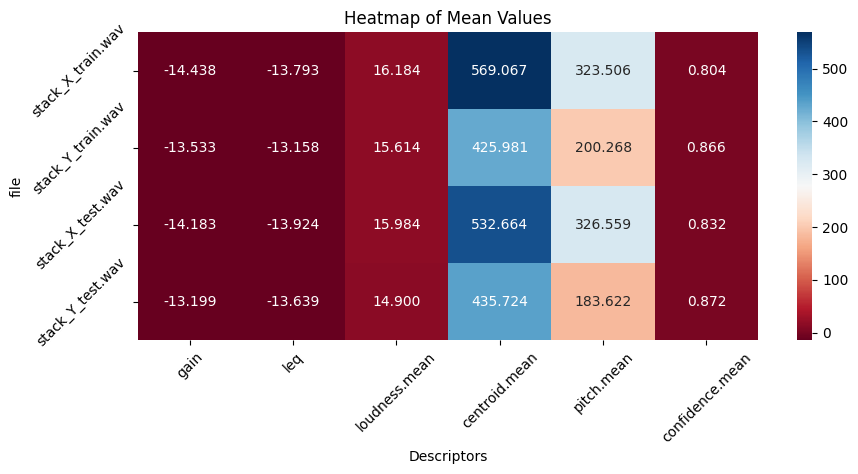

In [54]:
summary_df = df.set_index('file')

plt.figure(figsize=(10,4))
heatmap = sns.heatmap(summary_df.astype(float), annot=True, fmt=".3f", cmap='RdBu')

plt.title('Heatmap of Mean Values')
plt.xlabel('Descriptors')

heatmap.set_yticklabels(heatmap.get_yticklabels(), rotation=45)
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=45)

plt.show()

## Some audio features computed with librosa and torchaudio 

In [55]:
def compute_audio_features(path, sample_rate):
    # Load audio file
    waveform, _ = torchaudio.load(path)
    
    # Compute loudness
    loudness_transform = torchaudio.transforms.Loudness(sample_rate)
    loudness = loudness_transform(waveform).item()
    
    # Compute spectral centroid with torchaudio
    centroid_transform = torchaudio.transforms.SpectralCentroid(sample_rate)
    centroid_torchaudio = centroid_transform(waveform).mean().item()
    
    # Compute spectral centroid with librosa
    audio, _ = librosa.load(path, sr=sample_rate)
    centroid_librosa, std_librosa = librosa.feature.spectral_centroid(y=audio, sr=sample_rate)[0].mean(), \
                                     librosa.feature.spectral_centroid(y=audio, sr=sample_rate)[0].std()
    
    return loudness, centroid_torchaudio, centroid_librosa, std_librosa

In [56]:
files = ["stack_X_train.wav", "stack_Y_train.wav", "stack_X_test.wav", "stack_Y_test.wav"]
df_librosa = pd.DataFrame()

# Iterate over the files
for file in files:
    # Set the full path
    full_path = os.path.join(CONVERTED_DIR, file)
    
    # Compute the features
    loudness, centroid_torch, centroid_librosa, std_librosa = compute_audio_features(full_path, sample_rate)
    
    # Create a dictionary to store the features
    features = {'filename': file,
                'loudness': loudness,
                'centroid_torchaudio': centroid_torch,
                'centroid_librosa': centroid_librosa,
                'std_librosa': std_librosa}
    
    # Convert to DataFrame
    df_current = pd.DataFrame([features])

    # Append to the main DataFrame
    df_librosa = pd.concat([df_librosa, df_current])

# Reset the index of the DataFrame
df_librosa.reset_index(drop=True, inplace=True)


In [57]:
# Round to 3 decimal places
df_librosa = df_librosa.round(3)

df_librosa

,filename,loudness,centroid_torchaudio,centroid_librosa,std_librosa
0,stack_X_train.wav,-13.508,NaN,744.657,728.409
1,stack_Y_train.wav,-12.380,797.359,794.880,847.941
2,stack_X_test.wav,-13.740,NaN,749.383,757.073
3,stack_Y_test.wav,-12.927,791.628,779.919,841.741


In [58]:
get_media_length(CONVERTED_DIR)

Files in directory: audio/springset_converted

Processing file: audio/springset_converted/stack_Y_train.wav
Length in audio/springset_converted/stack_Y_train.wav: 2 minutes, 8.00 seconds
Number of elements in audio/springset_converted/stack_Y_train.wav: 2048000

Processing file: audio/springset_converted/stack_X_test.wav
Length in audio/springset_converted/stack_X_test.wav: 2 minutes, 8.00 seconds
Number of elements in audio/springset_converted/stack_X_test.wav: 2048000

Processing file: audio/springset_converted/stack_Y_test.wav
Length in audio/springset_converted/stack_Y_test.wav: 2 minutes, 8.00 seconds
Number of elements in audio/springset_converted/stack_Y_test.wav: 2048000

Processing file: audio/springset_converted/stack_X_train.wav
Length in audio/springset_converted/stack_X_train.wav: 2 minutes, 8.00 seconds
Number of elements in audio/springset_converted/stack_X_train.wav: 2048000



In [59]:
help(es.Pool)

Help on class Pool in module essentia.common:

class Pool(builtins.object)
 |  Pool(poolRep=None)
 |  
 |  Methods defined here:
 |  
 |  __getitem__(self, key)
 |  
 |  __init__(self, poolRep=None)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  add(self, key, value, validityCheck=False)
 |  
 |  clear(self)
 |  
 |  containsKey(self, key)
 |  
 |  descriptorNames(self, key=None)
 |  
 |  isSingleValue(self, name)
 |  
 |  merge(self, arg1, arg2=None, arg3=None)
 |  
 |  mergeSingle(self, key, value, mergeType='')
 |  
 |  remove(self, key)
 |  
 |  removeNamespace(self, namespace)
 |  
 |  set(self, key, value, validityCheck=False)
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the object (if defined)

